<a href="https://colab.research.google.com/github/gabriosilva/lunar-lander/blob/main/Lunar_Lander_Assignement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import the Required Libraries

## Install the Required Libraries

In [1]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]
!pip install imageio imageio-ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376102 sha256=c795d000eb9a3819608f82c95314854c6b5593edad27a4dc21fdebf193bacb5d
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


## Import the Required Libraries

In [2]:
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import pandas as pd

from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import random
from IPython.display import display
from IPython.display import Video

# Introduction
In this notebook, we will implement a Deep Q-Network (DQN) to solve the Lunar Lander environment from the OpenAI Gym. The Lunar Lander environment is a continuous state and discrete action space environment where the agent has to learn to land a spacecraft on the moon. The agent receives a reward for landing the spacecraft safely and a penalty for crashing the spacecraft. The environment is considered solved when the agent achieves an average reward of 200 over 100 consecutive episodes.

### Set the Device
We are setting the device to be used for training the network. If a GPU is available, we will use it; otherwise, we will use the CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Define the DQN Network
Here, we define the DQN network using the PyTorch library. The network consists of three fully connected layers with ReLU activation functions. The input size of the network is the state size, and the output size is the action size. The network is defined as a class that inherits from the nn.Module class. The forward method is used to define the forward pass of the network.

In [47]:
class DQNNetwork(nn.Module):
    """
    Implements a Deep Q-Network (DQN) using PyTorch's nn.Module as the base class.

    Attributes:
        seed (int): Random seed for reproducibility.
        state_size (int): Dimension of each state input.
        action_size (int): Number of possible actions.
        layer1 (torch.nn.Linear): First hidden layer.
        layer2 (torch.nn.Linear): Second hidden layer.
        layer3 (torch.nn.Linear): Output layer producing action values.

    Args:
        state_size (int): The dimensionality of the state space.
        action_size (int): The dimensionality of the action space.
        seed (int): Seed for random number generators to ensure reproducibility.
        hidden_size (int, optional): Number of nodes in the hidden layers. Defaults to 128.
    """

    def __init__(self, state_size, action_size, seed, hidden_size=128):
        super(DQNNetwork, self).__init__()
        self.seed =  torch.manual_seed(seed)
        self.state_size = state_size
        self.action_size = action_size
        self.layer1 = nn.Linear(state_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x (Tensor): The input state.

        Returns:
            Tensor: The output action values.
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


## Define the Replay Buffer
We define the replay buffer that stores the experiences of the agent. The replay buffer is used to store the experiences of the agent in the form of a tuple containing the state, action, reward, next state, and done flag. The replay buffer has a method to add experiences and a method to sample a batch of experiences for training the network.

In [48]:
class ReplayBuffer:
    """
    Implements a fixed-size buffer to store experience tuples.

    Attributes:
        memory (deque): Internal memory buffer that stores experiences.
        batch_size (int): Size of each training batch.
        experience (namedtuple): Namedtuple defining an experience for storage in the buffer.

    Args:
        buffer_size (int): Maximum size of the buffer.
        batch_size (int): Size of each training batch.
        seed (int): Random seed for reproducibility.
    """

    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """
        Adds an experience to the buffer.

        Args:
            state: The state observed from the environment.
            action: The action taken in the environment.
            reward: The reward received from the environment.
            next_state: The next state observed from the environment after the action is taken.
            done: Boolean flag indicating if the episode has ended.
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """
        Randomly samples a batch of experiences from memory.

        Returns:
            Tuple[Tensor]: Tuple of tensors corresponding to states, actions, rewards, next_states, and dones.
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """
        Returns the current size of internal memory.

        Returns:
            int: The current size of the memory buffer.
        """
        return len(self.memory)

## Define the DQN Agent and Hyperparameters
Apart from defining the DQN network and the replay buffer, we also define the DQN agent. The DQN agent has methods to take actions, learn from experiences, and update the target network. We also define the hyperparameters for training the DQN agent. These parameters can be tuned to improve the performance of the agent.

In [49]:
BUFFER_SIZE = 50_000
BATCH_SIZE = 128
UPDATE_INTERVAL = 10
GAMMA = 0.99
TAU = 1
LR = 1e-3

MAX_EPISODES = 2000
MAX_STEPS = 1000
SOLVED_THRESHOLD = 200
LOG_INTERVAL = 20

EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995

## Define the DQN Agent
The DQN Agent is responsible for taking actions, learning from experiences, and updating the target network. The agent has methods to take actions, learn from experiences, and update the target network. The agent also has a method to save the model weights to a file.

In [50]:
class DQNAgent:
    """
    Represents an agent that uses a Deep Q-Network (DQN) for learning policies based on the Q-learning algorithm.

    Attributes:
        state_size (int): The dimensionality of the state space.
        action_size (int): The dimensionality of the action space.
        seed (int): Random seed for reproducibility.
        q_network (DQNNetwork): The primary network used for estimating Q-values.
        target_network (DQNNetwork): The target network used for calculating target Q-values.
        optimizer (torch.optim.Adam): Optimizer for training q_network.
        memory (ReplayBuffer): Replay buffer for storing and sampling experiences.
        t_step (int): Internal counter to track when to update the target network.

    Args:
        state_size (int): The dimensionality of the state space.
        action_size (int): The dimensionality of the action space.
        seed (int): Seed for random number generators to ensure reproducibility.
    """
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.q_network = DQNNetwork(state_size, action_size, seed).to(device)
        self.target_network = DQNNetwork(state_size, action_size, seed).to(device)
        self.optmizer = optim.Adam(self.q_network.parameters(), lr=LR)
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        """
        Processes a step taken by the agent by saving the experience in replay memory and potentially
        learning from a sample of experiences from the memory.

        Args:
            state: The current state observed in the environment.
            action: The action taken by the agent.
            reward: The reward received after taking the action.
            next_state: The next state observed after taking the action.
            done: Boolean indicating whether the episode has finished.
        """
        self.memory.add(state, action, reward, next_state, done)
        self.t_step += 1
        if self.t_step % UPDATE_INTERVAL == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        """
        Updates Q-network based on a batch of experiences.

        Args:
            experiences (Tuple[torch.Tensor]): Tuple of tensors (states, actions, rewards, next_states, dones).
        """
        states, actions, rewards, next_states, dones = experiences
        action_values = self.q_network(next_states).detach()
        max_action_values = action_values.max(1)[0].unsqueeze(1)

        q_target = rewards + (GAMMA * max_action_values * (1 - dones))
        q_expected = self.q_network(states).gather(1, actions)

        loss = F.mse_loss(q_expected, q_target)
        self.optmizer.zero_grad()

        loss.backward()
        self.optmizer.step()

        self.update_target_network(self.q_network, self.target_network)

    def update_target_network(self, q_network, target_network):
        """
        Soft updates the target network parameters.

        Args:
            q_network (DQNNetwork): The primary network from which weights are copied.
            target_network (DQNNetwork): The target network to which weights are copied.
        """
        for source, target in zip(q_network.parameters(), target_network.parameters()):
            target.data.copy_(TAU * source.data + (1.0 - TAU) * target.data)

    def act(self, state, eps=0.0):
        """
        Returns actions for given state as per current policy.

        Args:
            state: The current state of the environment.
            eps (float): epsilon, for epsilon-greedy action selection.

        Returns:
            int: The action chosen by the agent.
        """
        rnd_val = random.random()
        if rnd_val < eps:
            return np.random.randint(self.action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())

    def save(self, path):
        """
        Saves the model state dictionary to the specified path.

        Args:
            path (str): File path to save the model state dictionary.
        """
        torch.save(self.q_network.state_dict(), path)

## Training Loop
To train the DQN agent, we define the training loop. In the training loop, we iterate over episodes and steps within each episode. We take actions, learn from experiences, and update the target network. We also keep track of the scores and the mean score over the last 100 episodes. The training loop continues until the environment is solved or the maximum number of episodes is reached.

### Initialize the Environment and Agent

In [51]:
env = gym.make('LunarLander-v2')

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"State size: {state_size}, Action size: {action_size}")
agent = DQNAgent(state_size, action_size, seed=42)

State size: 8, Action size: 4


### Train the DQN Agent

In [53]:
scores = []
score_window = deque(maxlen=100)
eps = EPS_START

for episode in range(1, MAX_EPISODES):
    state, info = env.reset()
    score = 0
    reached_terminal = False
    for step in range(MAX_STEPS):
        action = agent.act(state, eps)
        next_state, reward, done, truncated, info = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break

        if episode % (LOG_INTERVAL * 4) == 0:
            eps = max(EPS_END, EPS_DECAY * eps)

        if episode % LOG_INTERVAL == 0:
            mean_score = np.mean(score_window)
            print(f"Episode {episode}, Score: {score:.2f}, Eps: {eps:.2f}, Mean Score: {mean_score:.2f}")
            if mean_score >= SOLVED_THRESHOLD:
                print(f"Environment solved in {episode} episodes")
                print(f"Mean score: {mean_score:.2f}")
                agent.save("dqn_lunar_lander.pth")
                reached_terminal = True
                break
    score_window.append(score)
    scores.append(score)
    if reached_terminal:
        break
env.close()

Streaming output truncated to the last 5000 lines.
Episode 460, Score: 89.73, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 91.48, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 92.28, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 93.17, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 93.74, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 95.13, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 95.34, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 91.08, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 93.95, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 96.08, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 93.98, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 94.37, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 92.21, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 94.24, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 91.16, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 92.26, Eps: 0.01, Mean Score: -68.73
Episode 460, Score: 88.90, Eps: 0.01,

## Plotting the Resulting Scores [Reward x Episode]
Analying the scores obtained during the training process can help us understand how the agent is learning. We can plot the scores obtained during the training process to visualize the agent's learning progress.

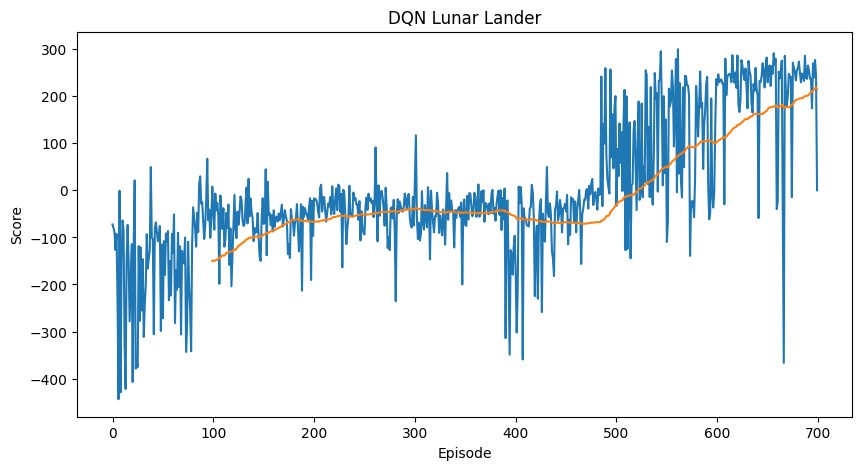

In [54]:
# Plot the scores
plt.figure(figsize=(10, 5))
plt.plot(scores)

# Calculate the rolling mean of the scores to smooth the curve
plt.plot(pd.Series(scores).rolling(100).mean(), label="Rolling mean")

# Plot the threshold line
plt.title("DQN Lunar Lander")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()

## Evaluate the Agent - Viewing the Agent's Behavior in the Environment
After training the agent, we can evaluate the agent's performance by running the agent in the environment and observing its behavior. We can render the environment and observe the agent's actions.

### Load the Trained Model
Since we have saved the model weights to a file, we can load the model weights and use the model to evaluate the agent.

In [55]:
agent.q_network.load_state_dict(torch.load('dqn_lunar_lander.pth'))

<All keys matched successfully>

### Evaluate the Agent

In [56]:
# Initialize the environment
env = gym.make('LunarLander-v2', render_mode="rgb_array")

# Define a trigger function to record the video
trigger = lambda t: t % 1 == 0
env = gym.wrappers.RecordVideo(env, video_folder="/videos", episode_trigger=trigger, disable_logger=True)

# Evaluate the agent
for i in range(1):
  termination, truncation = False, False
  eval_state, _ = env.reset()
  while not (termination or truncation):
    action = agent.act(eval_state)
    obs, rew, termination, truncated, info = env.step(action)
    eval_state = obs

### Display the Video

In [ ]:
video_path = 'videos/rl-video-episode-0.mp4'
display(Video(video_path, embed=True))